<h1 align='center'> SMC - TD6 </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>
<h3> Importance Sampling  </h3>

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Soit $X' = (X'_1, \dots, X'_d)$ un vecteur gaussian. Soit A une région définie par $$ A = \{ (x'_1, \dots, x'_d) \quad \quad \left|\prod_{i=1}^d x'_i\right| \leq C \}$$
On suppose que X est la variable X' tronquée à la région A.
On s'intéresse à l'estimation des espérances de type $E(\phi(X))$. 

In [2]:
def phi(x):
    """Returns log(1 + abs(x1 - x2))"""
    n, d = x.shape
    if d != 2:
        raise ValueError("dimension must be 2")
    xx = x[:, 0] - x[:, 1]
    y = np.log(1 + abs(xx))
    return y

Comme toujours, on commence par mettre en oeuvre un estimateur monte-carlo brutal: 
    $$ crude\_mc = \frac{1}{n}\sum_{i=1}^n \phi(x_i \iota_A(x_i)) $$


In [3]:
def crude_mc(n, d=2, c=0.1, seed=None):
    """Crude Monte Carlo estimator.
    
    n: number of samples
    d: number of features
    c: truncation float
    """
    
    rnd = np.random.RandomState(seed)
    X = rnd.randn(n, d)
    prodx = abs(np.prod(X, axis=1))
    X = X[prodx < c]
    # On prend la moyenne
    phibar = phi(X).mean()
    
    if np.isnan(phibar):
        return 0.
    return phibar
crude_mc(100, d=2, c=0.01)

0.4127585576494693

Puis un algorithme plus couteux les x_i ont été générées par un algorithme de rejet. Cette fonction nous donne une valeur très précise pour comparer avec notre IS.

In [4]:
def rejet_mc(n, d=2, c=1, seed=None):
    """Reject Monte Carlo estimator.
    
    n: number of samples
    d: number of features
    c: truncation float
    """
    
    rnd = np.random.RandomState(seed)
    mean = np.zeros(d)
    var = np.eye(d)
    X = np.zeros((n, d))

    i = 0
    while(True):
        x = rnd.randn(d)
        
        # Si on est dans A
        if abs(np.prod(x)) <= c:
            # On accepte x
            X[i] = x
            i += 1
        if i == n - 1:
            break
    
    # On prend la moyenne
    phibar = phi(X).mean()
    
    return phibar

In [5]:
rj = rejet_mc(10000, d=2, c=0.01)
rj

0.3149724138776013

En dimension $d \geq 2$, simuler à partir de X devient compliqué d'autant plus que la région A est étroite car plusieurs échantillons sont rejetés. On se propose ici d'estimer l'espérance en utilisant l'importance sampling:
étant donné une loi dite de proposition g, on note f la densité de la loi de X, et $E_h$ l'espérance pour un échantillon suivant une loi de densité $h$:

$$ E_f(\phi(X)) = \int \phi(X)f(x) = \int \phi(X)\frac{f(x)}{g(x)}g(x) = E_g\left(\phi(X)\frac{f(x)}{g(x)}\right) $$

On peut donc simuler un échantillon X à partir de la loi de g, à condition que g(x) = 0 implique f(x) = 0 (et donc l'intégrale sur le support de g a un sens).

En notant $w_i = \frac{f(x_i)}{g(x_i)}$, l'estimateur empirique IS:

$$ IS = \frac{1}{n} \sum_{i=1}^n w_i \phi(x_i) \to p.s \quad E_f(\phi(X)) $$

En plus, on peut remarquer que même si f et g sont connues à des constantes de normalisation près on peut prendre IS normalisé:
$$ IS = \frac{\sum_{i=1}^n w_i \phi(x_i)}{\sum_{i=1} w_i} $$

Pour évaluer votre importance sampling, pensez à calculer la taille d'échantillon effective qui correspond au nombre d'échantillons nécessaire pour obtenir la même variance IS avec un estimateur crude monte carlo, (et plus c'est grand mieux c'est).

## Question 1)
On commence par proposer comme loi de proposition g $\sim N(\mu, \Sigma)$ où $(\mu, \Sigma)$ sont estimés à partir de l'échantillon X (tronqué à A).

1. On simule une gaussienne Y et on obtient l'échantillon tronqué X
2. On estime $(\mu, \Sigma)$
3. On génére un échantillon Xg suivant $\sim N(\mu, \Sigma)$
4. On calcule les poids f(Xg) / g(Xg) 

In [6]:
from scipy.stats import multivariate_normal

def is_estimator_bad(n, d=2, c=0.1, seed=None):
    """IS estimator with gaussian proposal g"""
    
    rnd = np.random.RandomState(seed)
    mean = np.zeros(d)
    var = np.eye(d)
    
    # Echantillon X_a pour estimer mean_a et cov_a
    X = rnd.multivariate_normal(mean, var, size=n)
    prodx = np.prod(X, axis=1)
    X_a = np.zeros_like(X)
    mask = abs(prodx) <= c
    X_a[mask] = X[mask]
    
    # Estimation de mean_a et cov_a
    mean_a = X_a.mean(axis=0)
    cov_a = np.cov(X_a.T)

    # Echantillon suivant N(mean_a, cov_a)
    Xg = rnd.multivariate_normal(mean_a, cov_a, size=n)
    g = multivariate_normal.pdf(Xg, mean_a, cov_a)
    
    f = multivariate_normal.pdf(Xg, mean, var)
    # On calcule la densite f non normalisee
    prodx = abs(np.prod(Xg, axis=1))
    f[prodx > c] = 0.
    
    weights = f / g
    phi_g = phi(Xg)
    
    phibar = (phi_g * weights).sum() / weights.sum()
    
    effective_n = weights.sum() ** 2 / (weights ** 2).sum()
    
    return phibar, effective_n

In [7]:
is_estimator_bad(10000, d=2, c=0.1)

(0.33945997967720565, 828.8689079749682)

On a obtenu comme effective sample size 120, cela veut dire que 1000 échantillons avec cet IS "correspond" à un crude-monte carlo avec seulement 120 échantillons ...

Cet estimateur est a priori mauvais pour trois raisons:
- La variance estimée sera très bruitée car l'échantillon tronqué est de petite taille lorsque c est assez petit ...
- Pour c très petit, les variances suivant x et y seront très petites car très peu de points sont proches des axes (voir la région A ci-dessous) qui seront donc très sous-échantilonnés.
- Prendre une gaussienne comme loi de proposition risque de conduire à un estimateur avec une variance infinie (f^2 / g peut ne pas être intégrable)

## Question 2)

On change la loi de proposition g en prenant t-distribution (qui est plus épaisse aux bords qu'une gaussienne):

In [8]:
def is_estimator_good(n, d=2, c=0.1, phi=phi, df=2, seed=None):
    """IS estimator with t distribution"""
    
    rnd = np.random.RandomState(seed)
    
    # On genere une t de taille (n, d)
    Xg = rnd.standard_t(df, size=(n, d))
    # On calcule la densite de la loi t non normalisee
    g = (1 + (Xg ** 2).sum(axis=1) / df) ** (- (2 + df) / 2)
    # et celle de f (gaussienne tronquee)
    f = np.exp(- 0.5 * (Xg ** 2).sum(axis=1))
    prodx = abs(np.prod(Xg, axis=1))
    f[prodx > c] = 0.
    weights = f / g
    weights = np.nan_to_num(weights)

    phi_g = phi(Xg)
    phibar = (phi_g * weights).sum() / weights.sum()
    effective_n = weights.sum() ** 2 / (weights ** 2).sum()
    return np.nan_to_num(phibar), effective_n

In [9]:
is_estimator_good(100, d=2, c=0.01, df=3)

(0.292761808281981, 2.9990515427770603)

In [11]:
n, d, c = 1000, 2, 0.01
df = 2
N = 50
mc = np.array([crude_mc(n, d=d, c=c) for _ in range(N)])
is_1 = np.array([is_estimator_bad(n, d=d, c=c) for _ in range(N)])
is_2 = np.array([is_estimator_good(n, d=d, c=c, df=df) for _ in range(N)])

data = np.empty((N, 3))
data[:, 0] = mc
data[:, 1] = is_1[:, 0]
data[:, 2] = is_2[:, 0]

var_cr = mc.var()
var_is = is_2[:, 0].var()
print("Variance Crude MC:", var_cr)
print("Variance IS:", var_is)

Variance Crude MC: 0.0018656257227331907
Variance IS: 0.00204503420092666


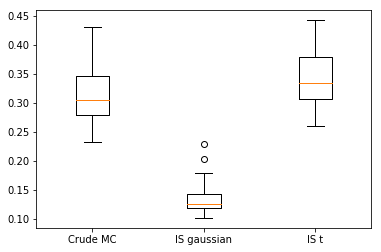

In [12]:
plt.figure()
plt.boxplot(data, labels=["Crude MC", "IS gaussian", "IS t"])
plt.show()

On veut maintenant chercher le nombre de degrés de libertés optimal pour notre loi de proposition t. On calcule donc l'effective sample size pour une grille de paramètres.

In [15]:
n, d, c = 10000, 2, 0.1
dfs = np.arange(1, 10, 1)
eff_n = np.zeros_like(dfs)
n_repeats = 50
for i, df in enumerate(dfs):
    mean_e = 0.
    for _ in range(n_repeats):
        _, e = is_estimator_good(n, d=d, c=c, df=df)
        mean_e += e / n_repeats
    eff_n[i] = mean_e

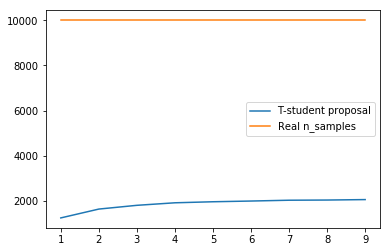

In [16]:
plt.figure()
plt.plot(dfs, eff_n, label="T-student proposal")
plt.plot(dfs, len(dfs) * [n], label="Real n_samples")
plt.legend()
plt.show()

À partir de 5, l'effective sample size ne varie plus beaucoup ...
